# SHAP Tutorial

In [ ]:
from IPython.display import VimeoVideo

VimeoVideo("745352008?h=3168320cef", width=800, height=600)

This tutorial is under the MPL 2.0 licence and is based on a [tutorial by Andrew Fairless](https://afairless.com/shap-tutorial/).



<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-model-agnostic/shap_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Our purpose is to look at how to use and interpret the Shapley values, plots,
    and other information produced by the SHAP package.

To learn more about Shapley values, the SHAP package, and how these are used to
    help us interpret our machine learning models, please refer to these
    resources:


- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)
    > Scott Lundberg, Su-In Lee

- [Consistent feature attribution for tree ensembles](https://arxiv.org/abs/1706.06060)
    > Scott M. Lundberg, Su-In Lee

- [Consistent Individualized Feature Attribution for Tree Ensembles](https://arxiv.org/abs/1802.03888)
    > Scott M. Lundberg, Gabriel G. Erion, Su-In Lee

- [A game theoretic approach to explain the output of any machine learning model.](https://github.com/slundberg/shap)
    >

- [Interpretable Machine Learning:  A Guide for Making Black Box Models Explainable.  5.9 Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
    > Christoph Molnar, 2019-12-17

- [Interpretable Machine Learning:  A Guide for Making Black Box Models Explainable.  5.10 SHAP (SHapley Additive exPlanations](https://christophm.github.io/interpretable-ml-book/shap.html)
    > Christoph Molnar, 2019-12-17

- [Interpretable Machine Learning with XGBoost](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27?gi=187ef710fdda)
    > Scott Lundberg, Apr 17, 2018

- [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
    > Dataman, Sep 14, 2019

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:

1. Warning: This notebook was not authored by Google. Click on 'Run anyway'.
2. Permit this notebook to access your Google Drive files? Click on 'Yes', and select your account.
3. Google Drive for desktop wants to access your Google Account. Click on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [ ]:
# Create a folder in your Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

In [ ]:
# Don't run this cell if you already cloned the repo in the first part of the tutorial
!git clone https://github.com/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI.git
# or !git clone git@github.com:HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI.git

In [ ]:
%cd Zero2Hero---Introduction-to-XAI/xai-model-agnostic

# Create a model to interpret

First, we'll load some packages.

In [1]:
# this is when using google-colab since it does not come with shap installed
try:
    import shap
except ImportError:
    print("shap not found, will install it first")
    !pip install shap
    import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge

from check_file import *

Now, we fix the random seeds to ensure reproducible results even though we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

Next, we'll again use the California housing dataset and stick to the first 2000 samples only, to keep runtimes short.
We will again split the dataset and fit the same model as in the Permutation importance tutorial to be able to compare explanations.

In [3]:
calif_house_data = fetch_california_housing()

In [4]:
cah_df = pd.DataFrame(calif_house_data['data'])
cah_df.columns = calif_house_data['feature_names']
cah_df['price'] = calif_house_data['target']
cah_df = cah_df[:2000]

feat_cols = cah_df.columns[:8]
target_col = "price"
prediction_col = "prediction"

print(cah_df.shape)
cah_df.head()

(2000, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [5]:
# split off the test data
df_train, df_test = train_test_split(cah_df, train_size=0.75, random_state=seed)

print(df_train.shape, df_test.shape)

# reset the indices since we dont care about the original indices anymore
# and otherwise we will get in trouble with pandas logical indexing *.iloc
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

(1200, 9) (300, 9) (500, 9)


In [6]:
df_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,3.6321,40.0,4.865874,1.047538,1305.0,2.215620,37.91,-122.30,2.091
1,4.6000,24.0,13.104167,2.250000,235.0,2.447917,38.92,-119.94,1.368
2,7.3089,48.0,7.283217,1.041958,685.0,2.395105,37.91,-122.28,3.312
3,1.9327,52.0,4.564045,1.011236,958.0,2.152809,37.86,-122.28,1.699
4,8.3188,12.0,8.481046,1.016993,2404.0,3.142484,37.81,-121.96,4.034


In [7]:
pipe = Pipeline([
    ("preprocessing", StandardScaler()),
    ("model", KernelRidge(kernel="rbf"))
])

pipe.fit(df_train[feat_cols], df_train[target_col])

df_train[prediction_col] = pipe.predict(df_train[feat_cols])

Let's take a peek at how our predictions compare to the actual house prices.

In [8]:
df_train[[target_col, prediction_col]].head()

,price,predictions
0,2.091,2.109646
1,1.368,1.227445
2,3.312,3.864086
3,1.699,1.681822
4,4.034,3.962818


We can look at the prediction error as a proportion of the target variable.

In [9]:
proportional_error = (df_train[target_col] - df_train[prediction_col]).abs() / df_train[target_col]
print('\n')
print(proportional_error.mean())
print(proportional_error.median())



0.15737320323113657
0.11674705768662286


In [10]:
# is the model performing reasonably on the training data?
pipe.score(df_train[feat_cols], df_train[target_col])

0.8083313004779416

In [ ]:
# is the model performing reasonably on the test data?
pipe.score(df_test[feat_cols], df_test[target_col])

As we are not so much concerned with the performance of the model, we will just keep it at that and do not try to improve further.

# Explaining predictions for an individual observation

Let's create some SHAP values to explain our model's predictions.

First of all we will run the shap Java initializer, that is needed later to create the plot.

The *shap.Explainer()* function uses the shap values to explain any machine learning model or python function. The model can be an object or a function. As data you should use a subset of your original training data, as the shap value calculation takes quite some time.

You can ignore the warnings that come from scikit_learn. It is just because we used a pandas DataFrame when fitting the model but the `shap` package internally seems to work with the model using numpy arrays instead which do not have the feature names attached any longer.

In [11]:
df_train[feat_cols].iloc[:100]

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

In [ ]:
shap.initjs()
# the first 100 rows including prediction and label
shap_df = df_train.iloc[:100]
# the first 100 rows only containing the features
x_train = shap_df[feat_cols]

explainer = shap.KernelExplainer(pipe.predict, x_train)
shap_values = explainer.shap_values(x_train)

Notice that the shap values matrix is the same size as our *x* matrix that
    contains all the feature values for each observation (i.e., each row of the
    matrix).

In [12]:
print('\n')
print('Features matrix - # rows, # columns:', x_train.shape)
print('\n')
print('SHAP values matrix - # rows, # columns:', shap_values.shape)



Features matrix - # rows, # columns: (100, 8)


SHAP values matrix - # rows, # columns: (100, 8)


That means that there is one SHAP value for each value in our feature matrix.
    In other words, each observation (row) has a SHAP value for each of its
    features (columns) that explains that feature's contribution to the model's
    prediction for that observation.

We can peek at the SHAP values just to see what they look like.

In [13]:
shap_values

array([[-1.93120971e-01, -2.58902206e-02, -4.58913423e-02,
        -4.11626116e-04,  2.42147243e-02,  2.71934906e-01,
         2.69703521e-02,  8.17300592e-02],
       [ 7.52076574e-02,  5.06222926e-02,  1.64318297e-01,
        -2.76592064e-02, -6.33245825e-02,  7.69345893e-02,
        -2.21769614e-01, -7.96994108e-01],
       [ 1.22388555e+00,  9.42677438e-02,  1.52922054e-01,
         5.78234280e-03,  1.44950162e-02,  1.73661037e-01,
         8.62510467e-02,  1.42710640e-01],
       [-6.61989356e-01,  1.95408161e-02, -4.92774180e-02,
        -3.13750110e-03,  5.66208379e-03,  2.66867574e-01,
         5.15472197e-02,  8.24981181e-02],
       [ 1.57251142e+00, -3.15120004e-02,  1.74316530e-01,
         6.63117169e-03,  8.98799487e-02, -3.83715928e-02,
         1.27793584e-01,  9.14592170e-02],
       [-6.04744523e-01,  4.52462032e-02, -8.27698661e-02,
        -7.86044581e-04,  1.05395108e-02,  4.17827221e-01,
         5.19953882e-02,  8.76279141e-02],
       [-5.80322089e-03, -6.015635

The SHAP package provides some visualizations to help us understand how much
    each feature contributes to each prediction.  Let's look at a prediction
    for a single observation (row) in our data set.
The SHAP values explain why a prediction for a single observation is different
    from the average prediction for all the observations in the data set.
    Here's our model's average prediction for our data set:

In [14]:
explainer.expected_value

1.9701100825144695

### Decision plot

Here is the SHAP package's *decision plot* for explaining why a single
    observation deviates from the average prediction:

1.6073083511862054


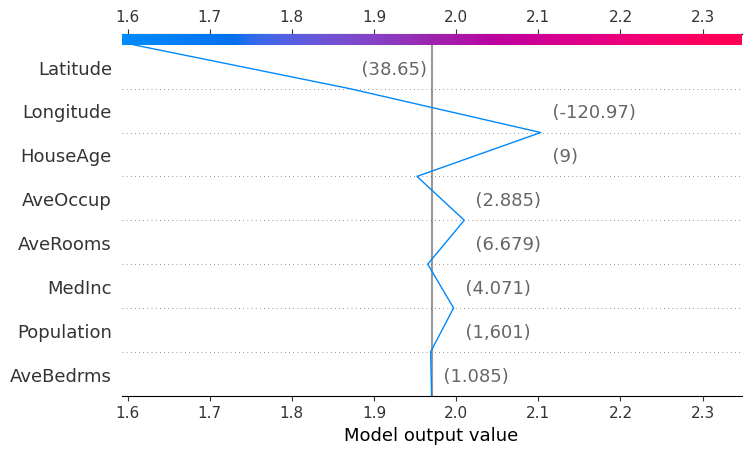

In [17]:
row = 1
print(shap_df[prediction_col].iloc[row])

shap.decision_plot(
    explainer.expected_value, shap_values[row], x_train.iloc[row])

It's probably easiest to read this plot from the bottom to the top.  At the
    bottom, the blue line starts at the average prediction for the
    whole data set. Then as we move up the plot row by row, we're looking at
    each feature's effect on the prediction for our single observation.  If
    the line moves a lot to the left or right, then the feature for that
    row changes the prediction by a lot.

As we move from the bottom to the top of the plot, we notice that *AveRooms*, *Population*, *AveBedrms* and *AveOccup* have only a small impact on the prediction, whereas *Latitude*, *MedInc* and *HouseAge* have larger effects.

The values in parentheses in each row show the value for each feature for the
    houses in this census block.  So, we can see that houses in this block
    are 14 years old on average and have an average occupancy of 2.55. Compared to
    all the houses in the data set, these values increase the median price of the houses.

As we move further up the plot, we notice that the census block's *Latitude* strongly decreases the predicted median price, according to our model.

When we sum up all the SHAP-calculated effects of the features, we see that
    the model predicts that the median price for houses in this census block
    is about 1.12. This can be read off the plot directly: it's where the blue squiggly line ends up at the top of the plot.
    The value for this sample is below 1.89 (from which the decision plot started at the bottom), the average predicted median price for all houses in all the census blocks in the data set we used to computed the shapley values.

## Exercise

Now, let's do a litte exercise to see if you understood this plot. Therefore, please execute the next cell:

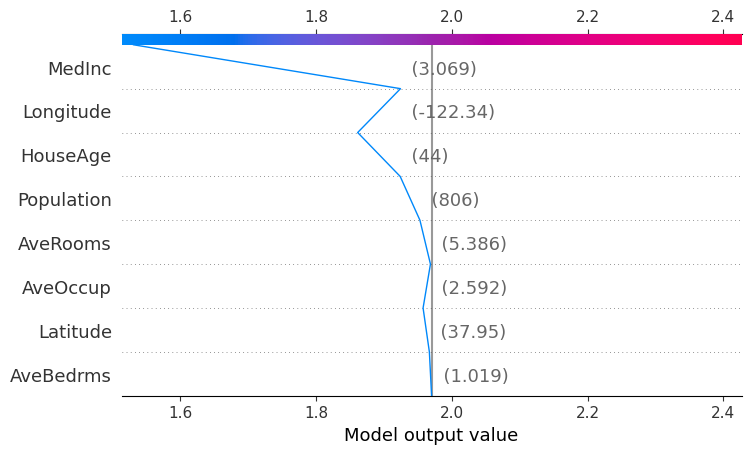

In [18]:
row = 96
shap.decision_plot(explainer.expected_value, shap_values[row, :], x_train.iloc[row, :])

Now, look at the plot and add the correct answers to the following lines of code:
- Which feature has the highest impact on the predicted price? *most_important_feature*
- Does the age of the house (39) increase or decrease the predicted price?
- Is the final prediction of the price higher or lower than the average prediction?

In [19]:
most_important_feature = None # 'feature_name'
house_age = None # 'increase' or 'decrease'
final_prediction = None # 'higher' or 'lower'

check_task_1(most_important_feature, house_age, final_prediction)

Please insert only strings.


## Force plot

The SHAP package provides another type of plot, the *force plot*, to visualize
    the same information as the *decision plot* that we discussed above:

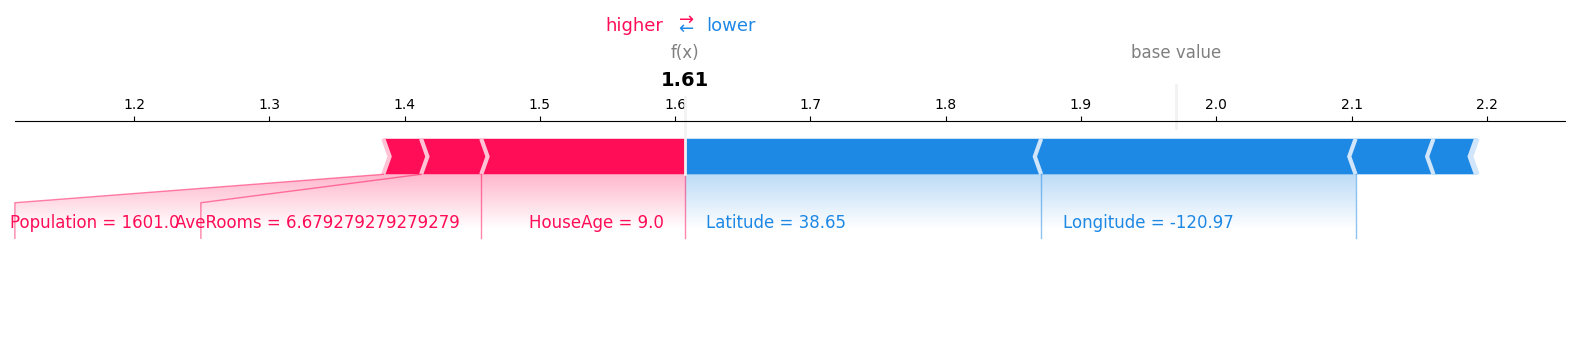

In [20]:
row = 1
shap.force_plot(explainer.expected_value, shap_values[row, :], x_train.iloc[row, :], matplotlib=True)

In this *force plot*, the information that we saw in the *decision plot* is
    vertically squashed, or compressed.  The effects of all the features now
    appear on a single row, instead of each feature appearing on its own row.
    This visualization is more compact, but we can still see the same
    information that we saw in the *decision plot*.

The average prediction for all houses in all the census blocks is labeled
    as the *base value* here which is about 1.89. The predicted median price for houses in this
    census block is 1.12 and is labeled as the *f(x)*.

Features that increase the predicted price from the *base value* are in red and
    are distinguished from each other by arrows pointing to the right.  Features
    that decrease the predicted price are in blue and have left-pointing
    arrows.  Features with larger effects on the prediction occupy more space
    in the row of arrows.  The two sets of features point to the *output value*.
    The names of the features and their values are printed below the row of
    arrows.

# Explaining predictions for the entire data set

### Force plot

Now that we understand the *force plot* for a single observation, we can look
    at a force plot for many observations.

In [21]:
n = 50

row_idx = np.random.randint(0, x_train.shape[0], n)
print(row_idx)

x_sample = x_train.iloc[row_idx]
shap_sample = shap_values[row_idx]

[37 12 72  9 75  5 79 64 16  1 76 71  6 25 50 20 18 84 11 28 29 14 50 68
 87 87 94 96 86 13  9  7 63 61 22 57  1  0 60 81  8 88 13 47 72 30 71  3
 70 21]


In [22]:
shap.force_plot(explainer.expected_value, shap_sample, x_sample)

In the *force plot* for a single observation, we had a horizontal row of red
    and blue arrows.  For this *force plot* of many observations, the rows of
    red and blue arrows have been rotated so that the arrows for a single
    observation are now vertical.  We can look horizontally across our entire
    sampled data set and easily see approximately how many observations have
    high predictions or average predictions or low predictions (where the red
    and blue areas meet). We can also see which features tend to push these
    predictions up or down. Hover with your mouse over section of the plot to get information about single samples.

### Feature importances summary plot

This *force plot* for many observations is terrific for looking at the model's
    predictions with granularity.  But what if we want a simpler summary of
    how important each feature is in making predictions for the entire data
    set -- something like *feature importance*?

The SHAP package provides this as a *summary plot*.  Here it is for our data:

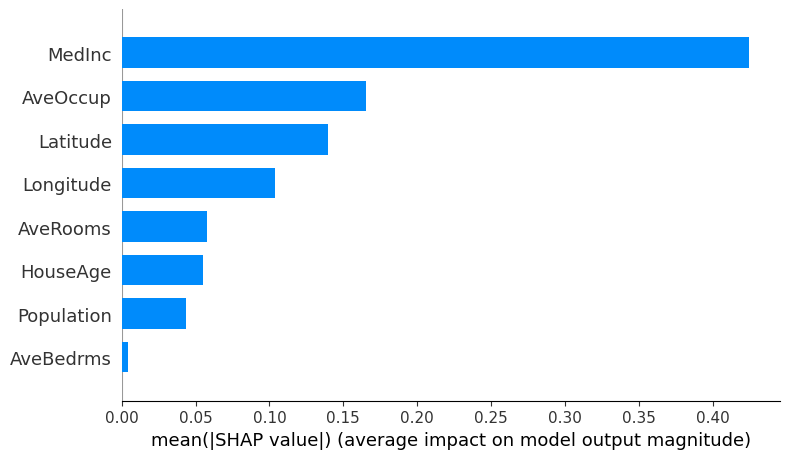

In [23]:
shap.summary_plot(shap_values, x_train, plot_type='bar')

These summaries, or feature importances, are calculated simply by taking the
    absolute values of all the Shapley values and averaging them for each
    feature.  Look closely, and you can see that the calculation below matches
    the plot *summary plot* above.

In [24]:
pd.Series(np.abs(shap_values).mean(axis=0),
          index=cah_df.columns[:x_train.shape[1]]).sort_values(ascending=False)

MedInc        0.424181
AveOccup      0.165393
Latitude      0.139952
Longitude     0.103887
AveRooms      0.057445
HouseAge      0.054827
Population    0.043741
AveBedrms     0.004337
dtype: float64

Just to make sure we understand what's happening here, let's look at the Shapley
    values again:

In [25]:
print(shap_values)

[[-1.93120971e-01 -2.58902206e-02 -4.58913423e-02 -4.11626116e-04
   2.42147243e-02  2.71934906e-01  2.69703521e-02  8.17300592e-02]
 [ 7.52076574e-02  5.06222926e-02  1.64318297e-01 -2.76592064e-02
  -6.33245825e-02  7.69345893e-02 -2.21769614e-01 -7.96994108e-01]
 [ 1.22388555e+00  9.42677438e-02  1.52922054e-01  5.78234280e-03
   1.44950162e-02  1.73661037e-01  8.62510467e-02  1.42710640e-01]
 [-6.61989356e-01  1.95408161e-02 -4.92774180e-02 -3.13750110e-03
   5.66208379e-03  2.66867574e-01  5.15472197e-02  8.24981181e-02]
 [ 1.57251142e+00 -3.15120004e-02  1.74316530e-01  6.63117169e-03
   8.98799487e-02 -3.83715928e-02  1.27793584e-01  9.14592170e-02]
 [-6.04744523e-01  4.52462032e-02 -8.27698661e-02 -7.86044581e-04
   1.05395108e-02  4.17827221e-01  5.19953882e-02  8.76279141e-02]
 [-5.80322089e-03 -6.01563529e-02 -2.66336882e-03 -5.55628733e-03
   2.05534739e-02  9.81720846e-04  1.58794778e-01  6.73905066e-02]
 [ 1.27156756e-01  4.53388490e-02 -1.71557739e-02  1.92171250e-03
   

In [26]:
print('SHAP values matrix - # rows, # columns:', shap_values.shape)

SHAP values matrix - # rows, # columns: (100, 8)


Remember, each row is an observation, which represents a census block of houses,
    and we have 100 census blocks.  Each column is a feature, and there are 8
    features.

All we did in the calculation above was to average all the (absolute values of
    the) 100 Shapley values in each column.  That gave us 8 sums, one for each
    feature, and those are our 8 feature importances for this model.  It's that
    simple.

Let's pause and consider this for a moment, because this is a really important
    point:  the feature importances for the entire model are calculated
    directly from their importances for individual observations.  In other
    words, the importances are consistent between the model's global behavior
    and its local behavior.  This consistency is a remarkable and really
    important characteristic that many model interpretability methods do not
    offer.

The SHAP package also provides a more granular look at feature importances for
    the entire data set.

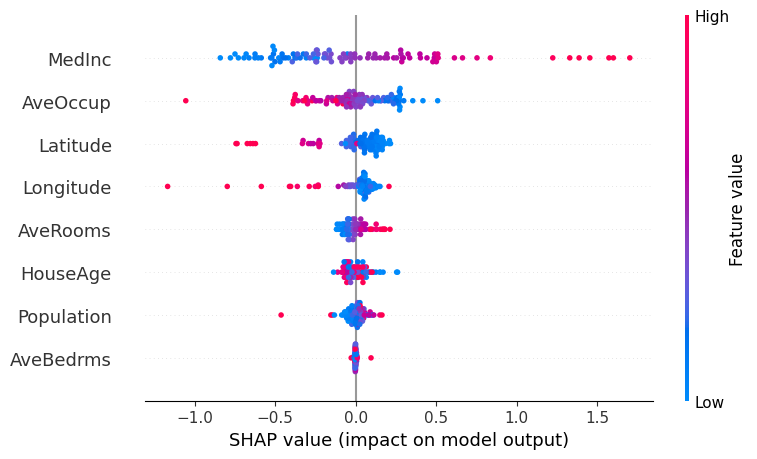

In [27]:
shap.summary_plot(shap_values, x_train)

Here the Shapley values of every observation are plotted for each feature.
    Additionally, the coloring indicates whether low (or high) values of each
    feature increase (or decrease) the model's predictions.

For example, we can see that high median incomes (*MedInc*) increase the
    predictions of house prices (i.e., the Shapley values are greater than zero)
    while low median incomes decrease those predictions (i.e., the Shapley
    values are < 0).  Also, the effects of *MedInc* on the model's predictions
    exhibit a positively skewed distribution:  most values of *MedInc*
    decrease the model's predictions, while a long tail of high *MedInc*
    values increase the model's predictions.

With *AveOccup*, there is a similar effect in the opposite direction. Low values of average occupancy
    increase the model's predictions.

# Check your learning

1. What does the shapley value tell you about the effect of the feature on a prediction?

2. What are the differences to the permutation importance method?

3. What is the main limitation of shapley values and why?

<details>
  <summary>Display answers</summary>


1. It tells you by how much the specific feature is moving the sample's prediction away from the mean prediction of all samples.
2.
- The shapley-value itself tells you something about the absolute effect of a feature on the output.
- To get the importance of a feature all possible combinations of feature subsets with and without the feature of interest are computed.
- Shapley is based only on model prediction and not on performance metric.
3. That it is computationally expensive, especially for large models and large features sets, as you need to compute all possible combinations of features.
</details>

# Exercise

Now let us do an exercise by using a completely new data set and trying to interpred the predictions. We will use the wine quality dataset.

In [28]:
# Load in the red wine data from the UCI ML website.
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep=';')
# Take a look
print(df.head(10))
# Data dimensionality (rows, colums)
print(df.shape)
# Data distributing
df.info()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   
5            7.4              0.66         0.00             1.8      0.075   
6            7.9              0.60         0.06             1.6      0.069   
7            7.3              0.65         0.00             1.2      0.065   
8            7.8              0.58         0.02             2.0      0.073   
9            7.5              0.50         0.36             6.1      0.071   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0

In [29]:
x = df.iloc[:, :11]
y = df['quality']
model = pipe
model.fit(x,y)
df['predictions'] = model.predict(x)

In [30]:
proportional_error = (df['quality'] - df['predictions']).abs() / df['quality']
print('\n')
print(proportional_error.mean())
print(proportional_error.median())



0.08769908259791512
0.07115571200554127


This concludes our exploration of how to use Shapley values and the SHAP
    package.  The resources cited at the top of this page can provide further
    information about Shapley values and SHAP.  Additionally, Christoph
    Molnar's book and Tim Miller's paper can provide further insight into the
    challenges and promise of machine learning interpretability:

- [Interpretable Machine Learning:  A Guide for Making Black Box Models Explainable.](https://christophm.github.io/interpretable-ml-book/)
    > Christoph Molnar, 2019-12-17

- [Explanation in Artificial Intelligence: Insights from the Social Sciences](https://arxiv.org/abs/1706.07269)
    > Tim Miller

# The end of our tutorial!